In [1]:
# LSTM for international airline passengers problem with regression framing
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Dense, LSTM, Input
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
pd.options.mode.chained_assignment = None
tf.random.set_seed(0)

In [2]:
# from google.colab import drive

# drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
#demandOneWeek is the one week data of load consumption of the building where the graph below plots its progress alont the week of studies
demandOneWeek = pd.read_csv("demand_1_week.csv", names=['load'])

In [3]:
demandFiveMonths = pd.read_csv("demand_jan_maio.csv", names=['load'])

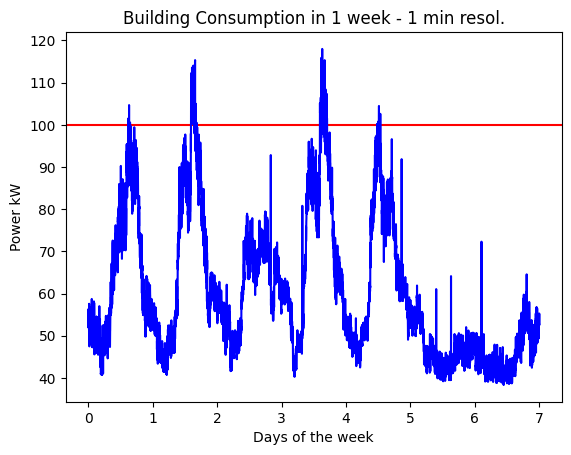

In [4]:
import matplotlib.pyplot as plt

# plot baseline and predictions
xweek = np.linspace(0, 7, 10081)
plt.axhline(y=100,color='r', linestyle='-') #possible limit stablished for reference
plt.plot(xweek, demandOneWeek[:]/1000, color = 'blue')
plt.title('Building Consumption in 1 week - 1 min resol.')
plt.xlabel('Days of the week')
plt.ylabel('Power kW')
plt.show()

In [5]:
entrance_times = pd.read_csv("entradas_1_week.csv") # entrance_times is car entries in on week in the parkinglot

# Converting columns to rows using transpose

entrance_times = entrance_times.transpose().reset_index().rename(columns={'index':'minutes'})

In [6]:
display(entrance_times)

,minutes
0,433
1,451
2,458
3,465
4,466
...,...
1317,1007
1318,1027.1
1319,1057
1320,1091


In [7]:
distances_traveled_since_full = pd.read_csv("distances.csv") #estimate of the distance traveled by each of the vehicles that entered the park (considering the entries recorded in the "entradas_1_week" file)

distances_traveled_since_full = distances_traveled_since_full.reset_index().rename(columns={'km':'distance'})

In [8]:
# train a model on the building load that we can use later
input_data_set = demandOneWeek # demandOneWeek or demandFiveMonths # source of training AND test data

scaler = MinMaxScaler(feature_range=(0, 1))
scaler = scaler.fit(input_data_set)
input_data_set = scaler.transform(input_data_set)
input_data_set = input_data_set.reshape(-1)

train_size = int(len(input_data_set) * 0.67)
training_data_set, test_data_set = input_data_set[0:train_size], input_data_set[train_size:]

def create_dataset(dataset, look_back, n_forecast): #creating points of datasets (from the data demandOneWeek) along the time after the training and testing
 dataX, dataY = [], []
 for i in range(look_back, len(dataset) - n_forecast + 1):
     a = dataset[i-look_back:i]
     dataX.append(a)
     dataY.append(dataset[i:i+n_forecast])
 return np.array(dataX), np.array(dataY)

In [9]:
look_back = 60 * 24 # TODO: change to 60 * 24 for 24 hours of lookback?

n_forecast = 60 * 24

trainX, trainY = create_dataset(training_data_set, look_back, n_forecast)
testX, testY = create_dataset(test_data_set, look_back, n_forecast)
X = trainX
Y = trainY

In [10]:
trainX.shape

(3875, 1440)

In [11]:
model = Sequential()
model.add(LSTM(units=20, return_sequences=True, input_shape=(look_back, 1)))
model.add(LSTM(units=20))
model.add(Dense(n_forecast))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X, Y, epochs=5, batch_size=144, verbose=1)



Epoch 1/5

122/122 [==============================] - 73s 578ms/step - loss: 0.0617
Epoch 2/5
122/122 [==============================] - 82s 677ms/step - loss: 0.0317
Epoch 3/5
122/122 [==============================] - 81s 663ms/step - loss: 0.0305
Epoch 4/5
122/122 [==============================] - 87s 713ms/step - loss: 0.0303
Epoch 5/5
122/122 [==============================] - 81s 661ms/step - loss: 0.0306


In [12]:
# save model
model.save('Scenario2_old.h5')

C:\Users\Akhod\AppData\Roaming\Python\Python310\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [13]:
scaled_input = scaler.transform(demandOneWeek [0:look_back])
input = np.array (scaled_input)
input = input.reshape(1, look_back)
output = model.predict (input)
output = scaler.inverse_transform (output)
display (output.shape)

1/1 [==============================] - 1s 610ms/step


(1, 1440)

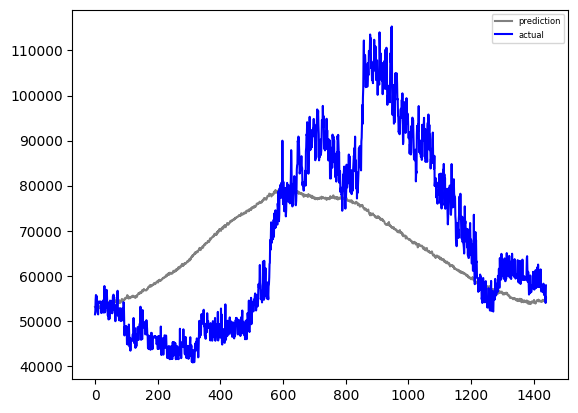

In [14]:
plt.plot(range (len(output[0])), output[0], color = 'grey', label='prediction')
plt.plot(range (len(output[0])), demandOneWeek [look_back:look_back+len(output[0])], color = 'blue', label='actual')
plt.legend(loc = 'best', fontsize=6)

In [16]:
# logic to count number of days from entradas time

current_day_count = 0 #pointer for the current day
day_start = 0 #varible that sets which day to star after the check by the system
daily_entrances = list() #lists the daily data to be considered

for i in range(1, len(entrance_times)):
    first = int(float(entrance_times.loc[i-1, "minutes"]))
    second = int(float(entrance_times.loc[i, "minutes"]))

    if second < first:
        current_day_count = 0
        daily_entrances.append(entrance_times[day_start:i])
        day_start = i

    current_day_count = current_day_count + 1 #checks if its data from and for another day (it does not consider the data if so)

daily_entrances.append(entrance_times[day_start:len(entrance_times)-1])

entrance_count_per_day = [] #counts the entrances for thje day in question and checks if its data from and for another day (it does not consider the data if so)
for i in range(0, len(daily_entrances)):
    entrance_count_per_day.append(len(daily_entrances[i]))

display(entrance_count_per_day)

[277, 292, 216, 280, 256]

1/1 [==============================] - 0s 77ms/step


C:\Users\Akhod\AppData\Local\Temp\ipykernel_25304\3215144884.py:33: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  arrival_time = int(round(float(ev_arrivals.iloc[i])))


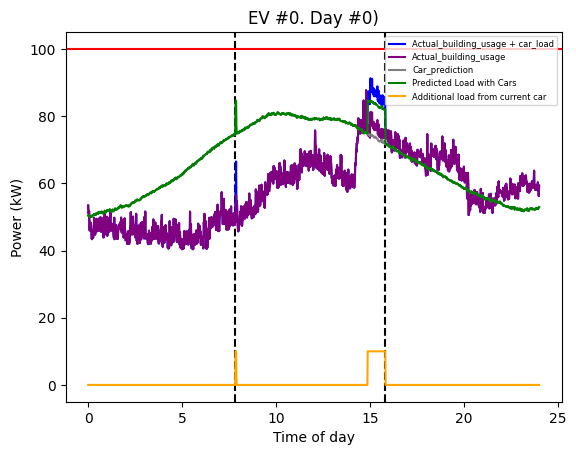

C:\Users\Akhod\AppData\Local\Temp\ipykernel_25304\3215144884.py:33: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  arrival_time = int(round(float(ev_arrivals.iloc[i])))


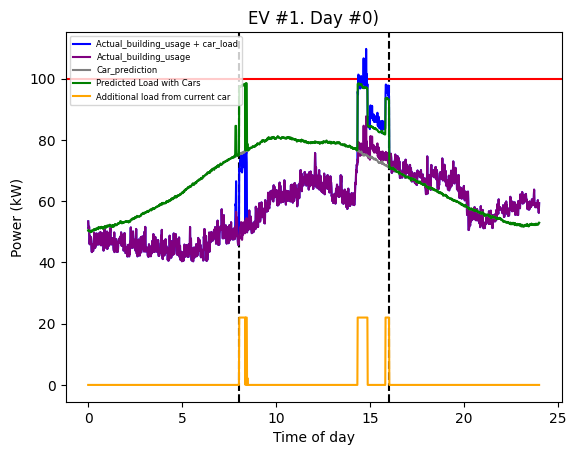

C:\Users\Akhod\AppData\Local\Temp\ipykernel_25304\3215144884.py:33: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  arrival_time = int(round(float(ev_arrivals.iloc[i])))


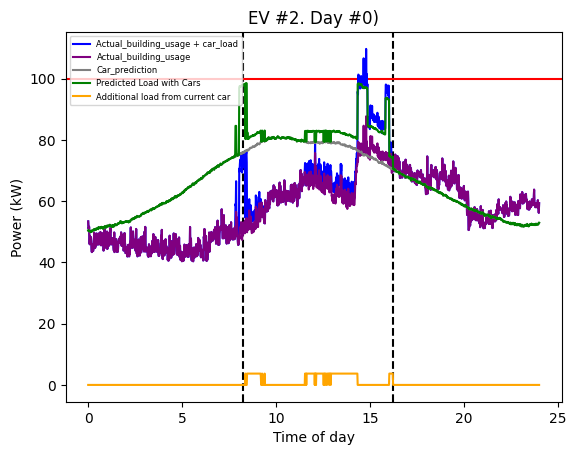

C:\Users\Akhod\AppData\Local\Temp\ipykernel_25304\3215144884.py:33: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  arrival_time = int(round(float(ev_arrivals.iloc[i])))


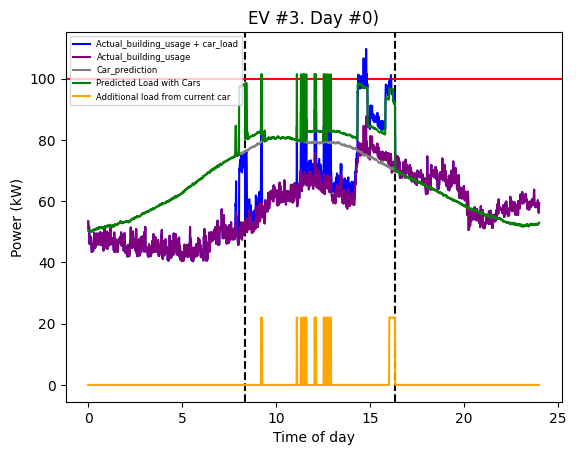

C:\Users\Akhod\AppData\Local\Temp\ipykernel_25304\3215144884.py:33: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  arrival_time = int(round(float(ev_arrivals.iloc[i])))


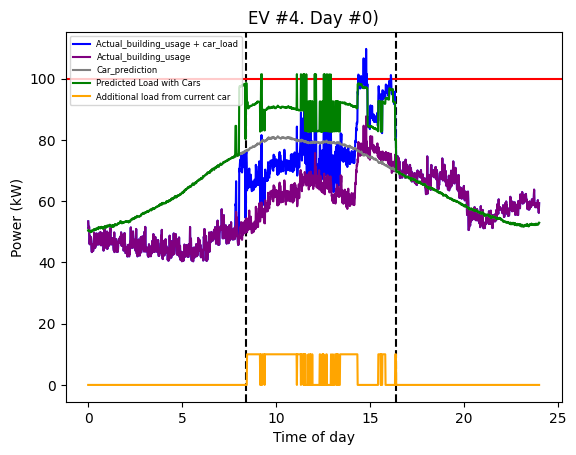

C:\Users\Akhod\AppData\Local\Temp\ipykernel_25304\3215144884.py:33: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  arrival_time = int(round(float(ev_arrivals.iloc[i])))


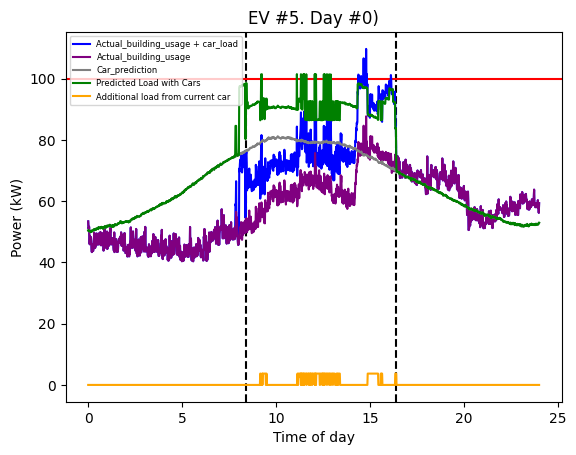

C:\Users\Akhod\AppData\Local\Temp\ipykernel_25304\3215144884.py:33: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  arrival_time = int(round(float(ev_arrivals.iloc[i])))


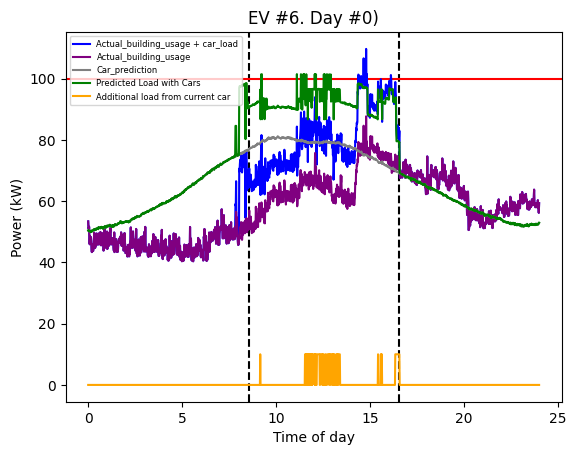

C:\Users\Akhod\AppData\Local\Temp\ipykernel_25304\3215144884.py:33: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  arrival_time = int(round(float(ev_arrivals.iloc[i])))


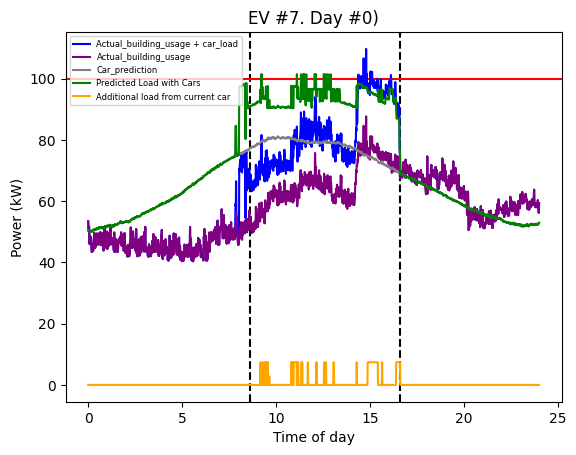

C:\Users\Akhod\AppData\Local\Temp\ipykernel_25304\3215144884.py:33: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  arrival_time = int(round(float(ev_arrivals.iloc[i])))


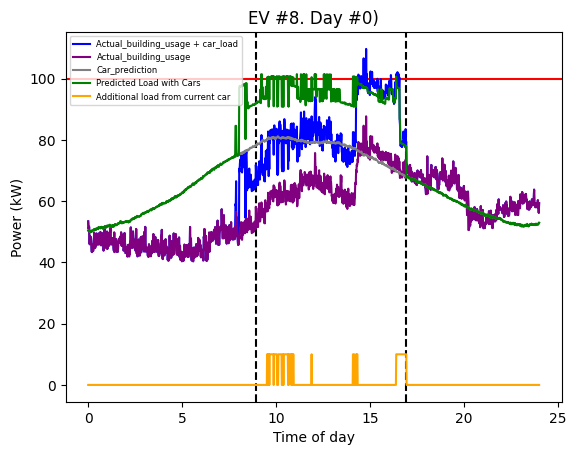

C:\Users\Akhod\AppData\Local\Temp\ipykernel_25304\3215144884.py:33: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  arrival_time = int(round(float(ev_arrivals.iloc[i])))


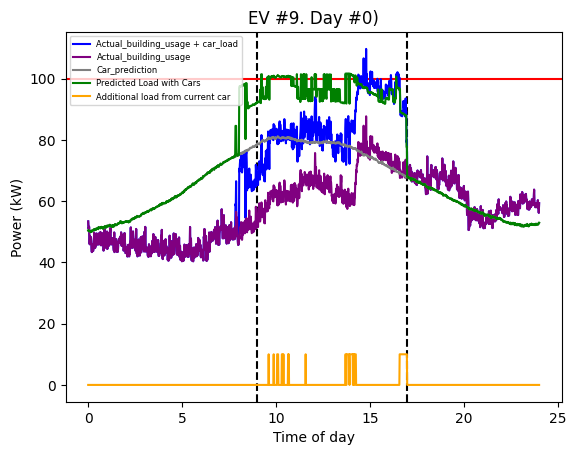

C:\Users\Akhod\AppData\Local\Temp\ipykernel_25304\3215144884.py:33: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  arrival_time = int(round(float(ev_arrivals.iloc[i])))


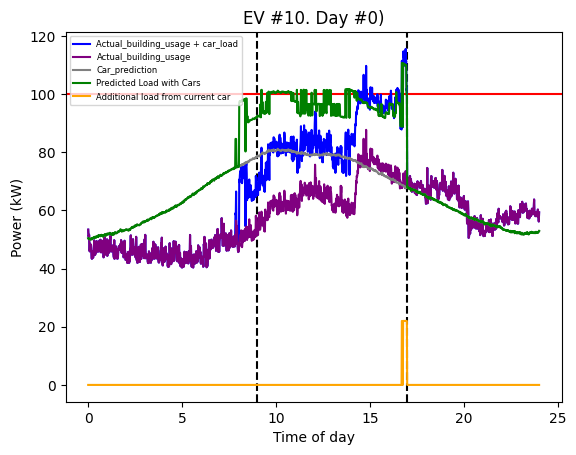

C:\Users\Akhod\AppData\Local\Temp\ipykernel_25304\3215144884.py:33: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  arrival_time = int(round(float(ev_arrivals.iloc[i])))


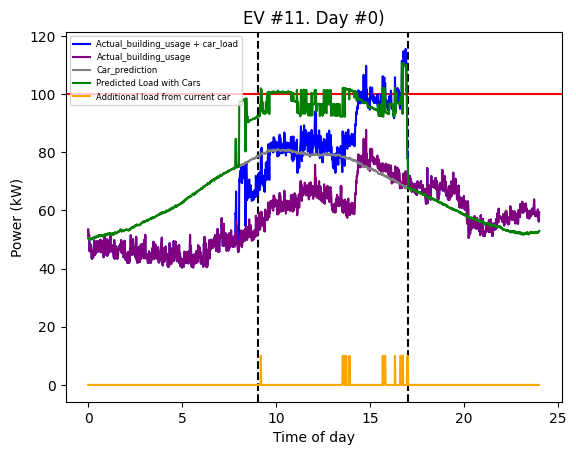

C:\Users\Akhod\AppData\Local\Temp\ipykernel_25304\3215144884.py:33: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  arrival_time = int(round(float(ev_arrivals.iloc[i])))


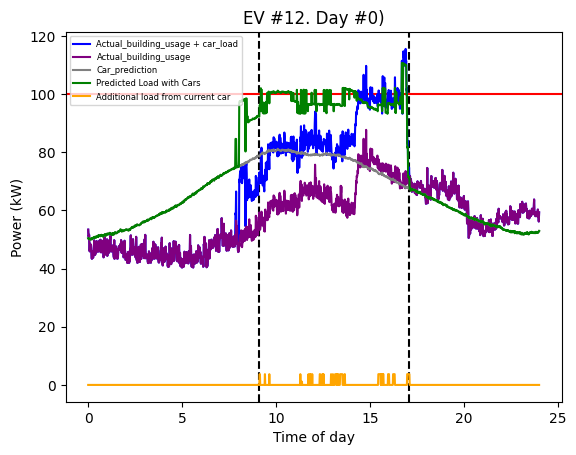

C:\Users\Akhod\AppData\Local\Temp\ipykernel_25304\3215144884.py:33: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  arrival_time = int(round(float(ev_arrivals.iloc[i])))


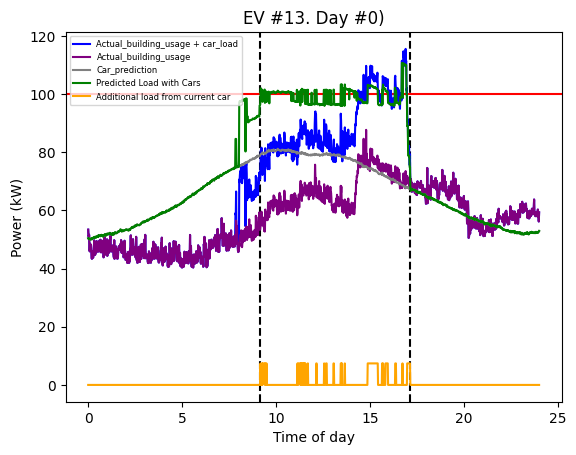

C:\Users\Akhod\AppData\Local\Temp\ipykernel_25304\3215144884.py:33: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  arrival_time = int(round(float(ev_arrivals.iloc[i])))


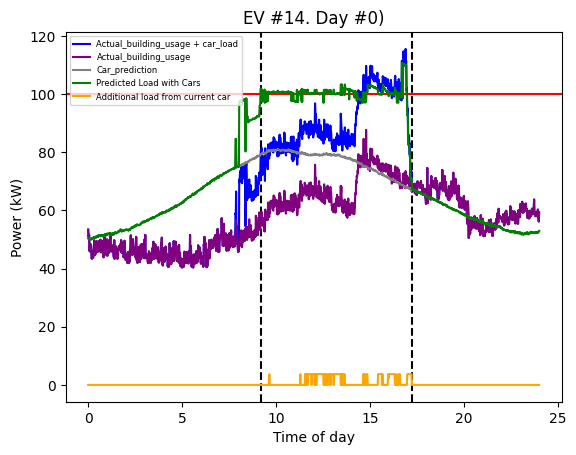

C:\Users\Akhod\AppData\Local\Temp\ipykernel_25304\3215144884.py:33: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  arrival_time = int(round(float(ev_arrivals.iloc[i])))


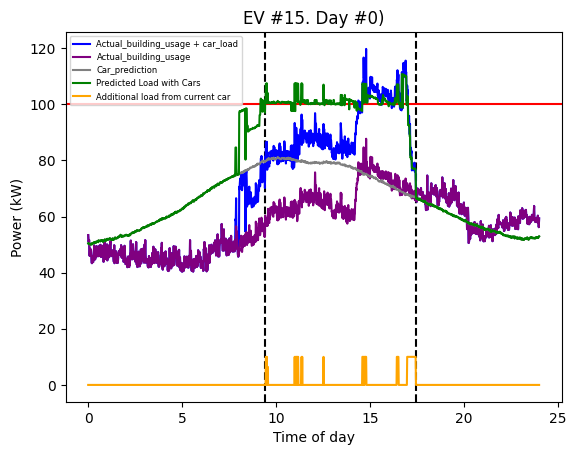

C:\Users\Akhod\AppData\Local\Temp\ipykernel_25304\3215144884.py:33: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  arrival_time = int(round(float(ev_arrivals.iloc[i])))


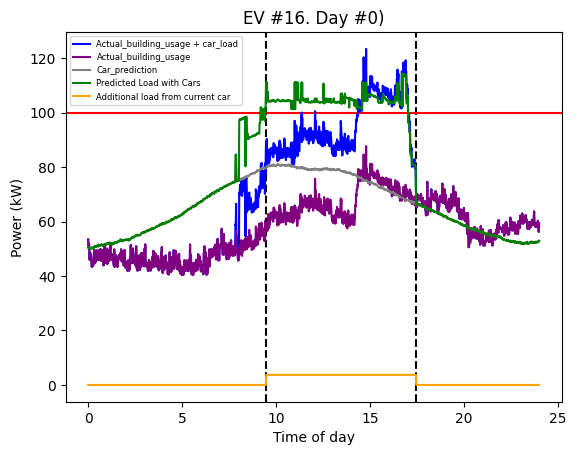

C:\Users\Akhod\AppData\Local\Temp\ipykernel_25304\3215144884.py:33: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  arrival_time = int(round(float(ev_arrivals.iloc[i])))


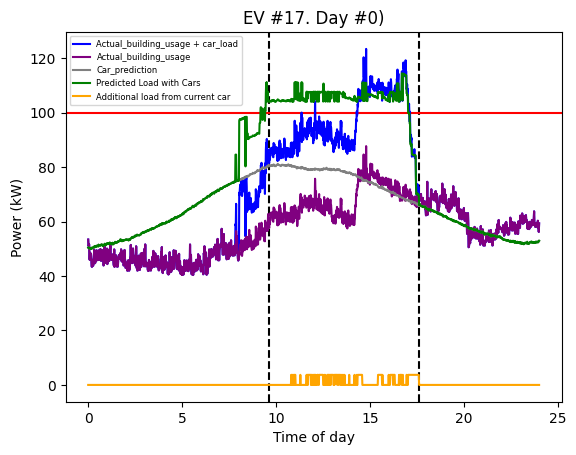

C:\Users\Akhod\AppData\Local\Temp\ipykernel_25304\3215144884.py:33: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  arrival_time = int(round(float(ev_arrivals.iloc[i])))


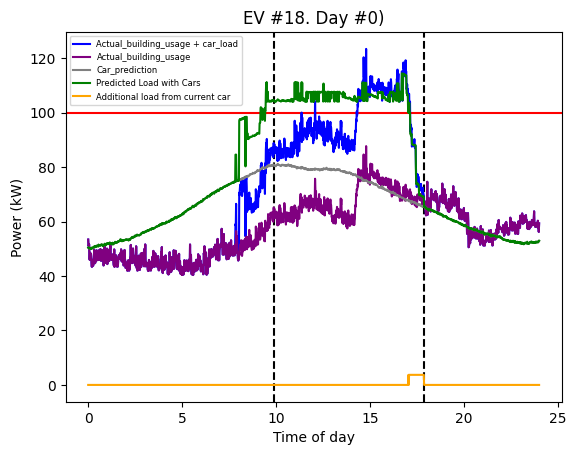

C:\Users\Akhod\AppData\Local\Temp\ipykernel_25304\3215144884.py:33: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  arrival_time = int(round(float(ev_arrivals.iloc[i])))


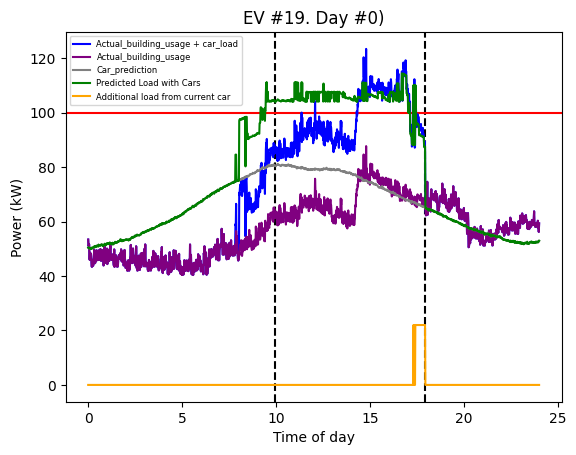

C:\Users\Akhod\AppData\Local\Temp\ipykernel_25304\3215144884.py:33: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  arrival_time = int(round(float(ev_arrivals.iloc[i])))


KeyboardInterrupt: 

In [17]:
from random import randint

max_car_connection_time = 8 * 60

# take a useful window of data from the five months
simulation_start_index = len(demandFiveMonths) - 1440 * (7+5)

sample_charge_powers = [3.7, 7.4, 10, 22] # examples of charging power taken from internet (kW)

for day_index in range(0,5):
  ev_arrivals = daily_entrances[day_index].sample(frac=0.2).sort_index()
  day_start_index = 1440*day_index + simulation_start_index
  day_end_index = 1440*(day_index+1) + simulation_start_index

  current_day_prediction_input = demandFiveMonths[day_start_index - look_back: day_start_index]

  scaled_input = scaler.transform(current_day_prediction_input)
  scaled_input = np.array (scaled_input)
  scaled_input = scaled_input.reshape(1, look_back)
  current_day_prediction_output = model.predict (scaled_input)
  current_day_prediction_output = scaler.inverse_transform (current_day_prediction_output)

  dataframe = pd.DataFrame(current_day_prediction_output[0], columns = ['predicted_load'])
  dataframe ['all_cars_load'] = float(0)
  dataframe ['current_car_load'] = float(0)
  dataframe ['original_index'] = dataframe.index#
  dataframe ['actual_load'] = demandFiveMonths[day_start_index:day_end_index].to_numpy()[:, 0]
  dataframe ['predicted_load_with_cars'] = dataframe ['predicted_load'] + dataframe ['all_cars_load']

  for i in range(0, len(ev_arrivals)):
    dataframe ['current_car_load'] = float(0)

    arrival_time = int(round(float(ev_arrivals.iloc[i])))
    current_car_distance = distances_traveled_since_full.loc[randint(0, len(distances_traveled_since_full) - 1), 'distance'] # pick at random

    current_car_recharge_required = 0.17 * current_car_distance * 1000 #Wh - average EV usage is 0.17kWh/km
    current_car_recharge_power = sample_charge_powers[randint(0, len(sample_charge_powers) - 1)] * 1000 #W

    dataframe = dataframe.sort_values(by=['predicted_load_with_cars'], ascending=True)
    dataframe.reset_index(inplace=True, drop=True)

    for j in range(0, 1440):
      minute = dataframe.loc[j,'original_index']
      if minute > arrival_time and minute < min(arrival_time + max_car_connection_time, 1440) and current_car_recharge_required > 0:
        recharge_in_one_minute = current_car_recharge_power / 60
        power_used = min(recharge_in_one_minute, current_car_recharge_required)
        current_car_recharge_required = current_car_recharge_required - power_used
        dataframe.loc[j,'all_cars_load'] += power_used * 60
        dataframe.loc[j,'current_car_load'] = power_used * 60
        dataframe.loc[j,'predicted_load_with_cars'] += power_used * 60

    dataframe = dataframe.sort_values(by=['original_index'], ascending=True)
    # dataframe.reset_index(inplace=True, drop=True)

    # add in the load for the right amount of time
    leading_zeros = np.zeros(int(arrival_time))
    exit_time = min(1440, arrival_time + max_car_connection_time)
    trailing_zeros = np.zeros(1440 - exit_time)

    xday = np.linspace(0, 24, 1440)

    actual_load_with_car = dataframe['actual_load'] + dataframe['all_cars_load']

    plt.clf()
    plt.axvline(x=arrival_time/60,color='black', linestyle='--')
    plt.axvline(x=exit_time/60,color='black', linestyle='--')
    plt.axhline(y=100,color='r', linestyle='-') #possible limit stablished for reference
    plt.plot(xday, actual_load_with_car/1000, color = 'blue', label = 'Actual_building_usage + car_load')
    plt.plot(xday, demandFiveMonths[day_start_index:day_end_index]/1000, color = 'purple', label = 'Actual_building_usage')
    plt.plot(xday, dataframe['predicted_load']/1000, color = 'grey', label='Car_prediction')
    plt.plot(xday, dataframe['predicted_load_with_cars']/1000, color = 'green', label='Predicted Load with Cars')
    plt.plot(xday, dataframe['current_car_load']/1000, color = 'orange', label='Additional load from current car')
    plt.title('EV #' + str(i) + '. Day #' + str(day_index) + ')')
    plt.xlabel('Time of day')
    plt.ylabel('Power (kW)')
    plt.legend(loc = 'best', fontsize=6)
    plt.show()


In [20]:
display((dataframe.index).shape)
display(demandFiveMonths[day_start_index:day_end_index].to_numpy()[:, 0].shape)

(1440,)

(1440,)

Scenario 3 starts here

In [53]:
from random import randint

max_car_connection_time = 8 * 60

# take a useful window of data from the five months
simulation_start_index = len(demandFiveMonths) - 1440 * (7+5)

sample_charge_powers = [3.7, 7.4, 10, 22] # examples of charging power taken from internet (kW)

for day_index in range(0,5):
  ev_arrivals = daily_entrances[day_index].sample(frac=0.2).sort_index()
  day_start_index = 1440*day_index + simulation_start_index
  day_end_index = 1440*(day_index+1) + simulation_start_index

  current_day = demandFiveMonths[day_start_index: day_end_index].to_numpy()[:, 0]

  dataframe = pd.DataFrame(current_day, columns = ['load'])
  dataframe ['all_cars_load'] = float(0)
  dataframe ['current_car_load'] = float(0)
  dataframe ['original_index'] = dataframe.index#
  dataframe ['building_load'] = current_day
  dataframe ['load_with_cars'] = dataframe ['building_load'] + dataframe ['all_cars_load']

  for i in range(0, len(ev_arrivals)):
    dataframe ['current_car_load'] = float(0)

    arrival_time = int(round(float(ev_arrivals.iloc[i])))
    current_car_distance = distances_traveled_since_full.loc[randint(0, len(distances_traveled_since_full) - 1), 'distance'] # pick at random

    current_car_recharge_required = 0.17 * current_car_distance * 1000 #Wh - average EV usage is 0.17kWh/km
    current_car_recharge_power = sample_charge_powers[randint(0, len(sample_charge_powers) - 1)] * 1000 #W

    dataframe = dataframe.sort_values(by=['load_with_cars'], ascending=True)
    dataframe.reset_index(inplace=True, drop=True)

    for j in range(0, 1440):
      minute = dataframe.loc[j,'original_index']
      if minute > arrival_time and minute < min(arrival_time + max_car_connection_time, 1440) and current_car_recharge_required > 0:
        recharge_in_one_minute = current_car_recharge_power / 60
        power_used = min(recharge_in_one_minute, current_car_recharge_required)
        current_car_recharge_required = current_car_recharge_required - power_used
        dataframe.loc[j,'all_cars_load'] += power_used * 60
        dataframe.loc[j,'current_car_load'] = power_used * 60
        dataframe.loc[j,'load_with_cars'] += power_used * 60

    dataframe = dataframe.sort_values(by=['original_index'], ascending=True)
    # dataframe.reset_index(inplace=True, drop=True)

    # add in the load for the right amount of time
    leading_zeros = np.zeros(int(arrival_time))
    exit_time = min(1440, arrival_time + max_car_connection_time)
    trailing_zeros = np.zeros(1440 - exit_time)

    xday = np.linspace(0, 24, 1440)


    plt.clf()
    plt.axvline(x=arrival_time/60,color='black', linestyle='--')
    plt.axvline(x=exit_time/60,color='black', linestyle='--')
    plt.axhline(y=100,color='r', linestyle='-') #possible limit stablished for reference
    plt.plot(xday, dataframe['load_with_cars']/1000, color = 'blue', label = 'Building usage + car_load')
    plt.plot(xday, dataframe ['building_load']/1000, color = 'purple', label = 'building usage')
    plt.plot(xday, dataframe['current_car_load']/1000, color = 'orange', label='Additional load from current car')
    plt.title('EV #' + str(i) + '. Day #' + str(day_index) + ')')
    plt.xlabel('Time of day')
    plt.ylabel('Power (kW)')
    plt.legend(loc = 'best', fontsize=6)
    plt.show()


Output hidden; open in https://colab.research.google.com to view.